In [1]:
from pathlib import Path
import torch
from matplotlib import pyplot as plt
import numpy as np
from sainomore.data import copying
from sainomore.xai import ElissabethWatcher, get_alphabet_projection

from data import LetterAssembler

In [2]:
model_id = "3i8b4895"

In [3]:
assembler = LetterAssembler(Path("quotes.txt"))
config = {
    "context_length": assembler.context_length,
    "characters": assembler.vocab_size,
}

In [4]:
watcher = ElissabethWatcher.load(model_id, on_cpu=True)

In [5]:
torch.random.manual_seed(62)
np.random.seed(62)
x, y = assembler.sample()

In [6]:
assembler.translate(x[0])

'{"quote":"“Most books on witchcraft will tell you that witches work naked. This is because most books on witchcraft were written by men.”","author":"Neil Gaiman","tags":["humor","men","witchcraft","witches","women"]}'

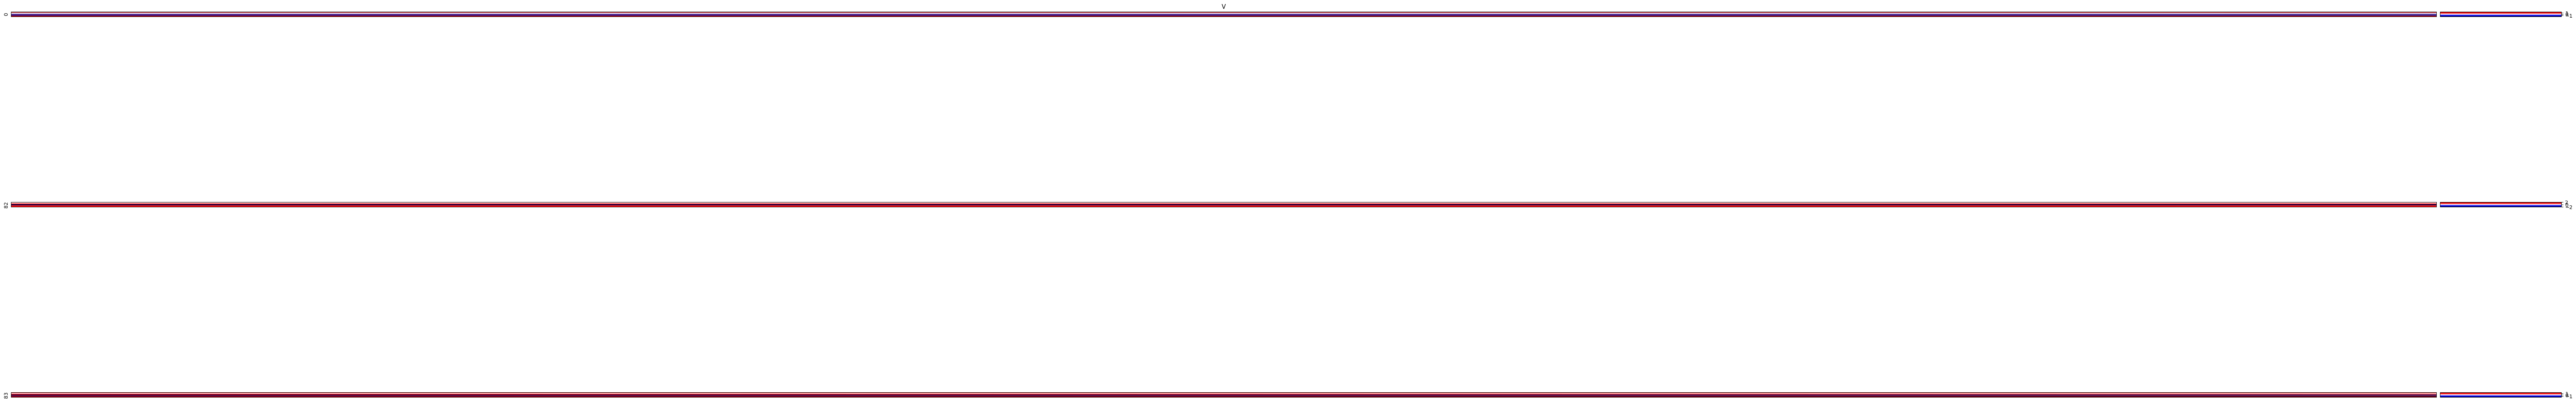

In [15]:
fig, ax = watcher.plot_alphabet_projection(
    q=False,
    k=False,
    v=True,
    n=4,
    tokens=torch.tensor([0, 82, 83]),
    transpose=True,
    figsize=(70, 20),
)
fig.savefig(
    f"copying_values_{model_id}.pdf",
    facecolor=(0, 0, 0, 0),
    bbox_inches="tight",
)

In [7]:
# fig, ax = watcher.plot_iss_time(
#     x[0],
#     x_axis=watcher.model(x).argmax(-1)[0, :],
#     append_dims=(1, ),
#     project_heads=True,
#     project_values=False,
#     figsize=(20, 4),
# )
# fig, ax = watcher.plot_iss(
#     x[0],
#     append_dims=(1, ),
#     project_heads=False,
#     project_values=False,
#     figsize=(10, 20),
# )

In [18]:
fig, ax = watcher.plot_query_key_time(
    x[0],
    weighting=0,
    names=("query", "key"),
    cmap="tab10",
    # x_axis=x[0],
    project_heads=False,#tuple(torch.where(W_H.abs()[0] > 5)[0].numpy()),
    # reduce_dims={0: 0},
    figsize=(20, 30),
)

KeyError: "No hook named 'Q' found"

In [25]:
watcher.model(torch.tensor([[0]])).shape

torch.Size([1, 1, 103])

In [20]:
fig, ax = watcher.plot_values_time(
    x[0],
    x_axis=x[0],
    project_heads=False,#tuple(torch.where(W_H.abs()[0] > 5)[0].numpy()),
    # reduce_dims={0: 0},
    figsize=(20, 5),
)

IndexError: index out of range in self

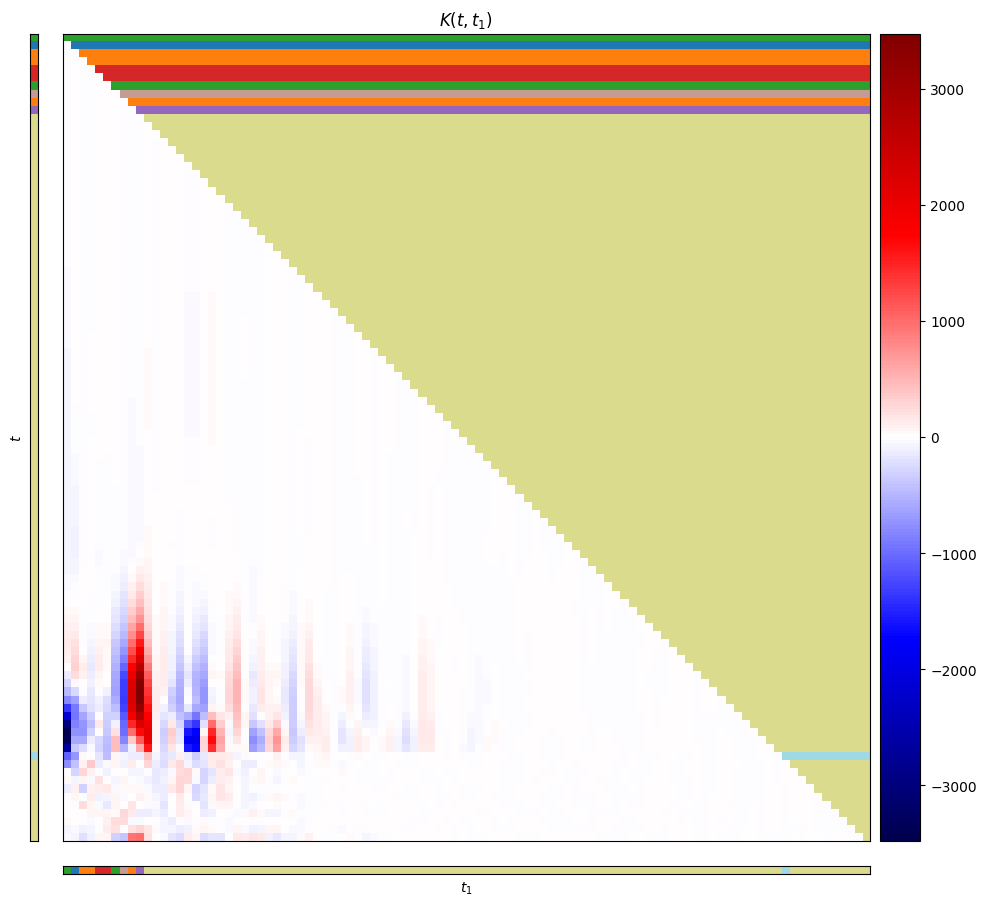

In [26]:
fig, ax = watcher.plot_attention_matrices(
    x[0],
    # total=True,
    cmap="seismic",
    share_cmap=False,
    log_cmap=False,#(10, 1),
    causal_mask=True,
    only_kernels=None,
    project_heads=True,#tuple(torch.where(W_H.abs()[0] > 5)[0].numpy()),
    center_zero=True,
    cmap_example="tab20",
    figsize=(10, 10),
)
fig.savefig(
    f"copying_attention_{model_id}.pdf",
    facecolor=(0, 0, 0, 0),
    bbox_inches="tight",
)

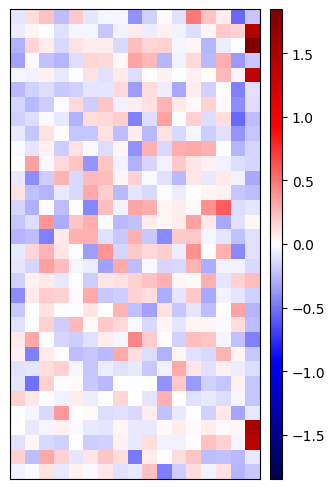

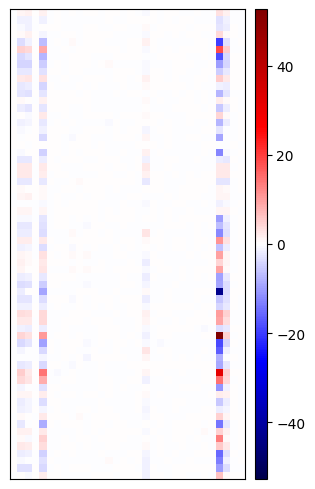

In [48]:
fig, ax = watcher.plot_parameter_matrix(
    "layers.0.levels.0.weightings.0.P_Q.transform.0.weight",
    figsize=(10, 5),
)
fig, ax = watcher.plot_parameter_matrix(
    "layers.0.levels.0.weightings.0.P_Q.transform.2.weight",
    # log_cmap=(0.1, 1.0),
    figsize=(10, 5),
)

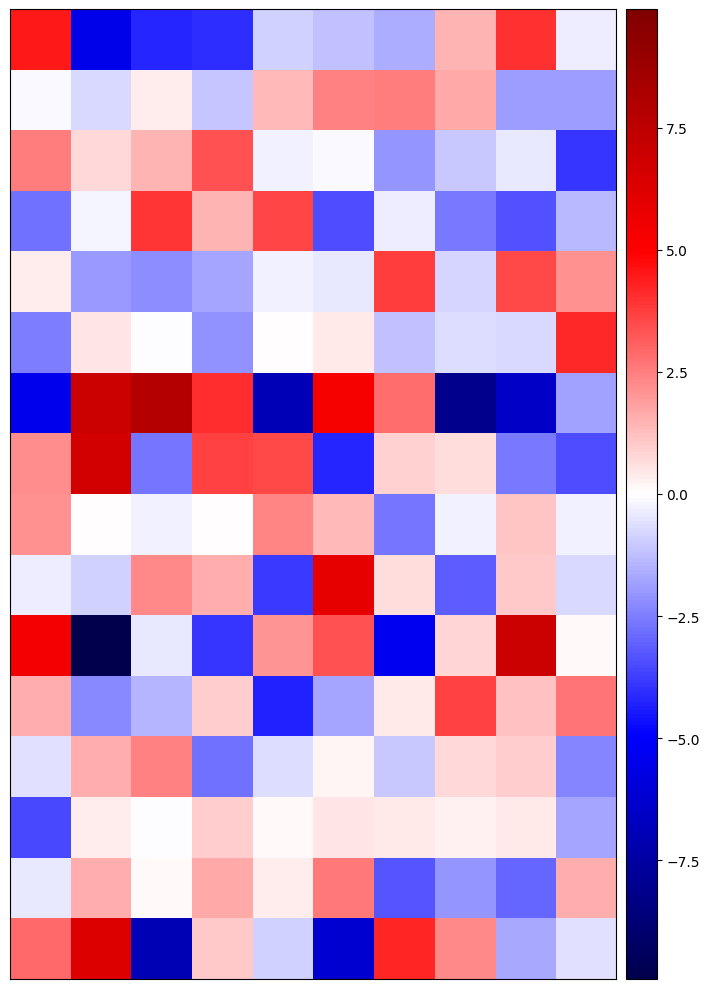

In [ ]:
fig, ax = watcher.plot_parameter_matrix(
    "layers.0.W_O",
    reduce_dims={2: 0},
    append_dims=(0,1,),
    figsize=(10, 10),
)

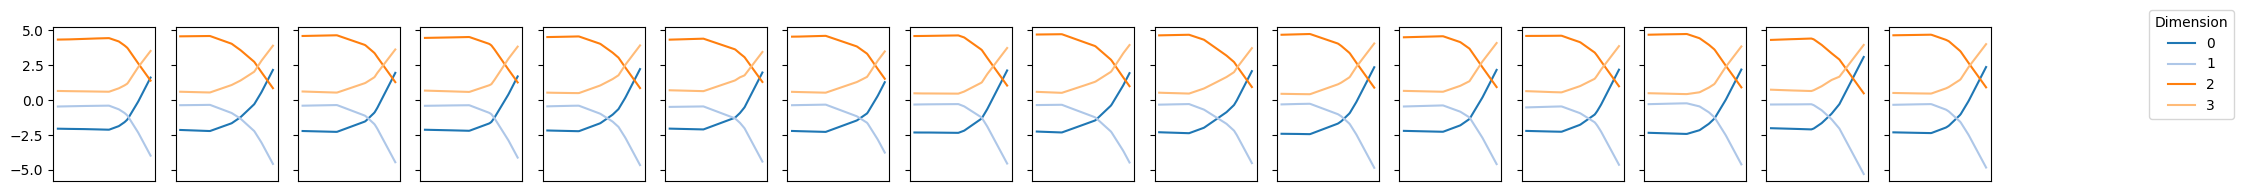

In [25]:
fig, ax = watcher.plot_qkv_probing(
    which="q",
    layer=0,
    length=0,
    weighting=0,
    reduce_dims={2: 0},
    append_dims=(2,),
    figsize=(25, 2),
)

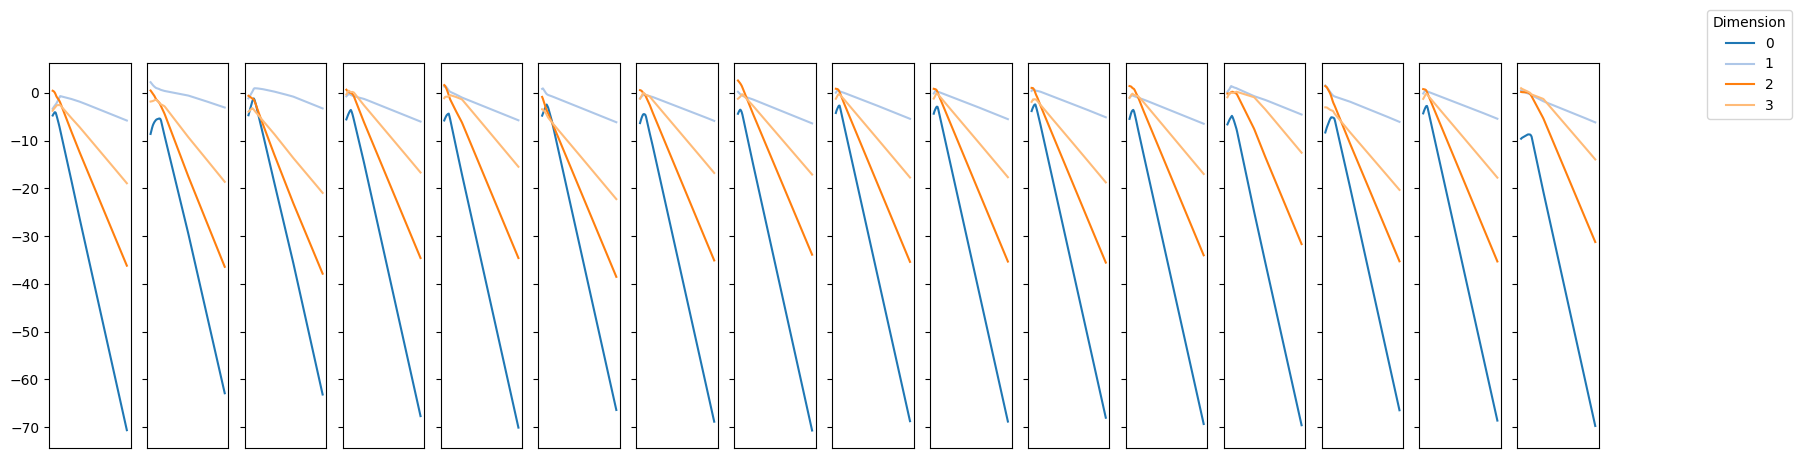

In [ ]:
fig, ax = watcher.plot_qkv_probing(
    which="k",
    layer=0,
    length=0,
    weighting=0,
    reduce_dims={2: 0},
    append_dims=(2,),
    figsize=(20, 5),
)

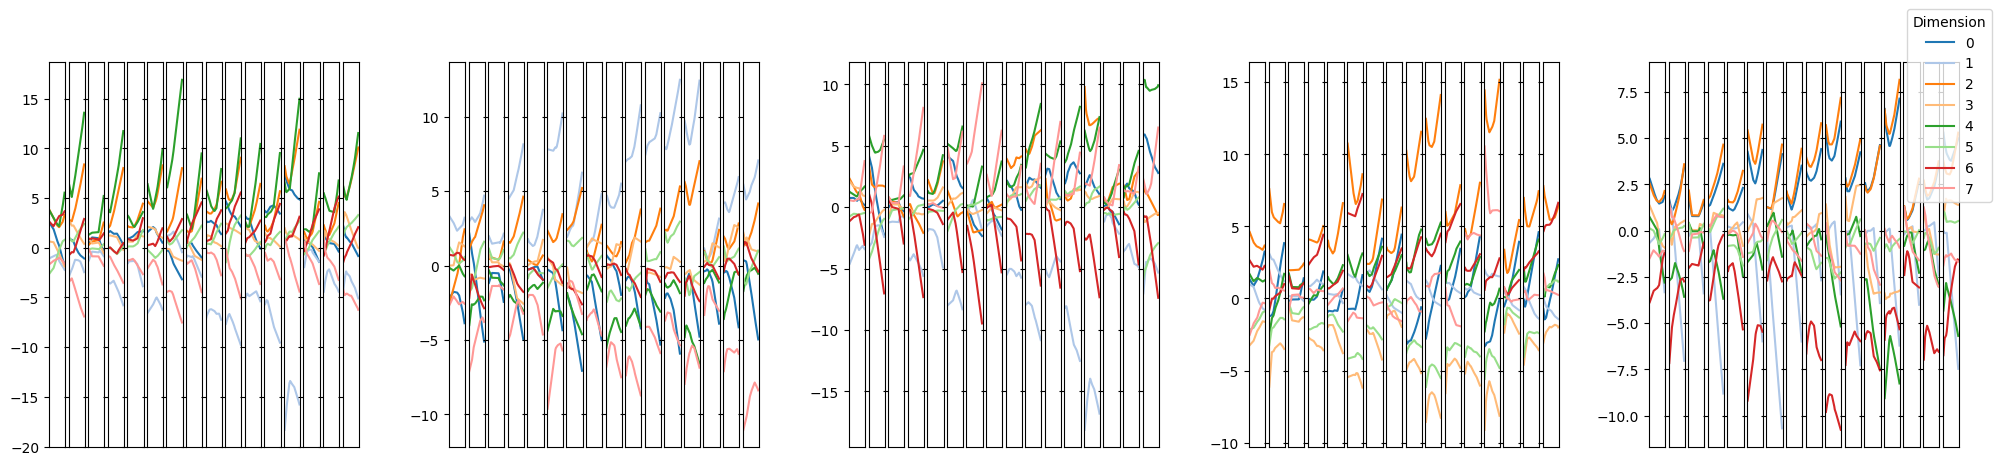

In [17]:
fig, ax = watcher.plot_qkv_probing(
    which="v",
    layer=0,
    length=0,
    weighting=0,
    reduce_dims={2: 0},
    append_dims=(2, ),
    figsize=(20, 5),
)